# Copyright Netherlands eScience Center <br>
** Function     : Compare atmospheric meridional energy transport (MERRA2,ERA-Interim,JRA55)** <br>
** Author       : Yang Liu ** <br>
** First Built  : 2019.04.06 ** <br>
** Last Update  : 2019.04.06 ** <br>
Description     : The code aims to compare the atmospheric meridional energy transport
                  calculated from different atmospheric reanalysis datasets. In this,
                  case, this includes MERRA II from NASA, ERA-Interim from ECMWF and
                  JRA55 from JMA.<br>

Return Value    : NetCFD4 data file<br>
Dependencies    : os, time, numpy, netCDF4, sys, matplotlib, logging<br>
variables       : Atmospheric Meridional Energy Transport   ERA-Interim     MERRA2       JRA55<br>
                  Oceanic Meridional Energy Transport       ORAS4           GLORYS2V3    SODA3<br>
Caveat!!        : Spatial and temporal coverage<br>
                  Atmosphere<br>
                  ERA-Interim   1979 - 2016<br>
                  MERRA2        1980 - 2016<br>
                  JRA55         1979 - 2015<br>
                  Ocean<br>
                  GLORYS2V3     1993 - 2014<br>
                  ORAS4         1958 - 2014<br>
                  SODA3         1980 - 2015<br>
                  NEMO ORCA0083 1979 - 2012<br>
                  The full dataset of ORAS4 is from 1958. However, a quality report from
                  Magdalena from ECMWF indicates the quality of data for the first
                  two decades are very poor. Hence we use the data from 1979. which
                  is the start of satellite era.<br>
                  The full dataset of ORAS4 is from 1958.<br>
                  Data from 20N - 90N are taken into account!<br>

In [1]:
import sys
sys.path.append("/home/ESLT0068/NLeSC/Computation_Modeling/Bjerknes/Scripts/META")
import numpy as np
import time as tttt
from netCDF4 import Dataset,num2date
import os
import platform
import sys
import logging
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
# generate images without having a window appear
#matplotlib.use('Agg')
import matplotlib.pyplot as plt
import pandas
from scipy import stats

In [2]:
# constants
constant = {'g' : 9.80616,      # gravititional acceleration [m / s2]
            'R' : 6371009,      # radius of the earth [m]
            'cp': 1004.64,      # heat capacity of air [J/(Kg*K)]
            'Lv': 2264670,      # Latent heat of vaporization [J/Kg]
            'R_dry' : 286.9,    # gas constant of dry air [J/(kg*K)]
            'R_vap' : 461.5,    # gas constant for water vapour [J/(kg*K)]
            }

In [3]:
# specify data path
#datapath_ERAI = '/home/yang/workbench/Core_Database_AMET_OMET_reanalysis/ERAI/postprocessing'
datapath_ERAI = '/home/ESLT0068/WorkFlow/Core_Database_AMET_OMET_reanalysis/ERAI/postprocessing'
#datapath_MERRA2 = '/home/yang/workbench/Core_Database_AMET_OMET_reanalysis/MERRA2/postprocessing'
datapath_MERRA2 = '/home/ESLT0068/WorkFlow/Core_Database_AMET_OMET_reanalysis/MERRA2/postprocessing'
#datapath_JRA55 = '/home/yang/workbench/Core_Database_AMET_OMET_reanalysis/JRA55/postprocessing'
datapath_JRA55 = '/home/ESLT0068/WorkFlow/Core_Database_AMET_OMET_reanalysis/JRA55/postprocessing'
datapath_JRA55_Mayer = '/home/ESLT0068/WorkFlow/Core_Database_AMET_OMET_reanalysis/warehouse_met/From_Michael'
# specify output path for the netCDF4 file
#output_path = '/home/yang/NLeSC/PhD/Paperwork/Article/AMET_OMET/figures'
output_path = '/home/ESLT0068/NLeSC/PhD/Paperwork/Article/AMET_OMET/ESD/figures/review'

In [4]:
# 60N
lat_ERAI_60 = 40
lat_MERRA2_60 = 80
lat_JRA55_60 = 52

# make a dictionary for instereted sections (for process automation)
lat_interest = {}
lat_interest_list = [60]
lat_interest['ERAI'] = [lat_ERAI_60]
lat_interest['MERRA2'] = [lat_MERRA2_60]
lat_interest['JRA55'] = [lat_JRA55_60]

In [5]:
dataset_ERAI = Dataset(datapath_ERAI + os.sep + 'model_daily_075_1979_2016_E_zonal_int.nc')
dataset_MERRA2 = Dataset(datapath_MERRA2 + os.sep + 'AMET_MERRA2_model_daily_1980_2016_E_zonal_int.nc')
dataset_JRA55 = Dataset(datapath_JRA55 + os.sep + 'AMET_JRA55_model_daily_1979_2015_E_zonal_int.nc')

dataset_ERAI_point = Dataset(datapath_ERAI + os.sep + 'model_daily_075_1979_2016_E_point.nc')
dataset_MERRA2_point = Dataset(datapath_MERRA2 + os.sep + 'AMET_MERRA2_model_daily_1980_2016_E_point.nc')
dataset_JRA55_point = Dataset(datapath_JRA55 + os.sep + 'AMET_JRA55_model_daily_1979_2015_E_point.nc')
dataset_JRA55_Mayer_point = Dataset(datapath_JRA55_Mayer + os.sep + 'jra55_TEDIV_dirc_wo_vapour_2005-2005_T63.nc')

# from 1979 to 2016
# from 20N - 90N
# total energy transport
AMET_E_ERAI = dataset_ERAI.variables['E'][:,:,40]/1000 # from Tera Watt to Peta Watt
AMET_E_MERRA2 = dataset_MERRA2.variables['E'][:,:,80]/1000 # from Tera Watt to Peta Watt
AMET_E_JRA55 = dataset_JRA55.variables['E'][:,:,53]/1000 # from Tera Watt to Peta Watt

AMET_E_JRA55_int_polar = np.sum(dataset_JRA55.variables['E'][:,:,:53]/1000,2)
# point
AMET_E_ERAI_point = dataset_ERAI_point.variables['E'][:,:,40,:]/1000 # from Tera Watt to Peta Watt
AMET_E_MERRA2_point = dataset_MERRA2_point.variables['E'][:,:,80,:]/1000 # from Tera Watt to Peta Watt
AMET_E_JRA55_point = dataset_JRA55_point.variables['E'][:,:,:,:]/1000 # from Tera Watt to Peta Watt
# from Mayer
AMET_E_JRA55_Mayer_point = dataset_JRA55_Mayer_point.variables['TEDIV_dirc_novap_ms'][:,::-1,:] # year 2005

year_ERAI = dataset_ERAI.variables['year'][:]        # from 1979 to 2016
year_MERRA2 = dataset_MERRA2.variables['year'][:]    # from 1980 to 2016
year_JRA55 = dataset_JRA55.variables['year'][:]      # from 1979 to 2015

latitude_ERAI = dataset_ERAI.variables['latitude'][:]
latitude_MERRA2 = dataset_MERRA2.variables['latitude'][:]
latitude_JRA55 = dataset_JRA55.variables['latitude'][:]

longitude_ERAI = dataset_ERAI_point.variables['longitude'][:]
longitude_MERRA2 = dataset_MERRA2_point.variables['longitude'][:]
longitude_JRA55 = dataset_JRA55_point.variables['longitude'][:]

In [7]:
print (latitude_JRA55[50:55])
print (latitude_MERRA2[80])

[61.49753  60.935913 60.37429  59.81267  59.251053]
60.0


In [6]:
# devided by area
dx_ERAI = 2 * np.pi * constant['R'] * np.cos(2 * np.pi * latitude_ERAI / 360) / len(longitude_ERAI)
dx_MERRA2 = 2 * np.pi * constant['R'] * np.cos(2 * np.pi * latitude_MERRA2 / 360) / len(longitude_MERRA2)
dx_JRA55 = 2 * np.pi * constant['R'] * np.cos(2 * np.pi * latitude_JRA55 / 360) / len(longitude_JRA55)

dy_ERAI = np.pi * constant['R'] / (240)
#dy_MERRA2 = np.pi * constant['R'] / (240)
dy_JRA55 = np.pi * constant['R'] / (320)

# calculate area weighted AMET by Mayer
AMET_E_JRA55_Mayer_point_area = np.zeros(AMET_E_JRA55_Mayer_point.shape, dtype=float)

for i in np.arange(len(latitude_JRA55)):
    # change the unit to terawatt
    AMET_E_JRA55_Mayer_point_area[:,i,:] = AMET_E_JRA55_Mayer_point[:,i,:]* dx[i] / 1E+15

#AMET_E_ERAI_point_noA = AMET_E_ERAI_point / 2 * np.pi * constant['R'] * np.cos(2 * np.pi * latitude_ERAI[40] / 360)
#AMET_E_MERRA2_point_noA = AMET_E_MERRA2_point * 1E+12 / dx_MERRA2[80] / dy_MERRA2
#AMET_E_JRA55_point_noA = AMET_E_JRA55_point / 2 * np.pi * constant['R'] * np.cos(2 * np.pi * latitude_JRA55[53] / 360)

In [ ]:
# calculate the standard deviation of AMET
# ERA-Interim
AMET_E_ERAI_std = np.std(AMET_E_ERAI[:],0)
print ('The standard deviation of AMET from ERA-Interim is (in peta Watt):')
print (AMET_E_ERAI_std)
# JRA55
AMET_E_JRA55_std = np.std(AMET_E_JRA55[:],0)
print ('The standard deviation of AMET from JRA55 is (in peta Watt):')
print (AMET_E_JRA55_std)

In [9]:
AMET_ERAI_full_annual_mean_max = np.amax(AMET_E_ERAI,0)
AMET_JRA55_full_annual_mean_max = np.amax(AMET_E_JRA55,0)

AMET_ERAI_full_annual_mean_min = np.amin(AMET_E_ERAI,0)
AMET_JRA55_full_annual_mean_min = np.amin(AMET_E_JRA55,0)

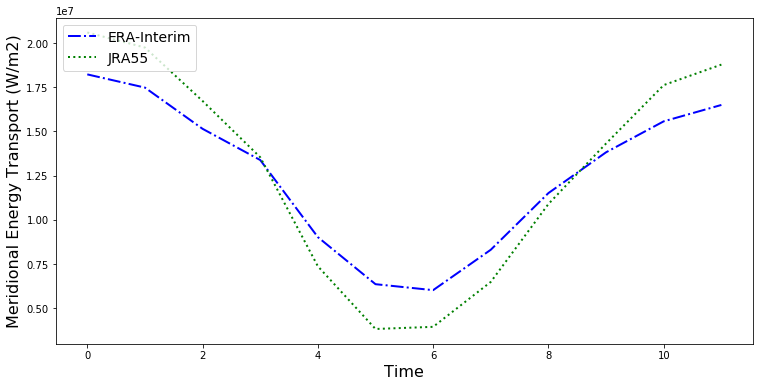

In [19]:
fig9= plt.figure()
plt.plot(np.arange(12),np.sum(np.mean(AMET_E_ERAI_point_noA[:],0),1),'b-.',linewidth=2.0,label='ERA-Interim')
plt.plot(np.arange(12),np.sum(np.mean(AMET_E_JRA55_point_noA[:],0),1),'g:',linewidth=2.0,label='JRA55')
#plt.title('Running Mean of AMET Anomalies at %dN with a window of %d months' % (lat_interest_list[i],window))
fig9.set_size_inches(12.5, 6)
plt.xlabel("Time",fontsize=16)
#plt.xticks(np.linspace(0, 456, 39), year_ERAI)
#plt.xticks(rotation=60)
plt.ylabel("Meridional Energy Transport (W/m2)",fontsize=16)

plt.legend(frameon=True, loc=2, prop={'size': 14})
plt.show()
fig9.savefig(output_path + os.sep + 'Comp_AMET_wm2.png', dpi = 300)
plt.close(fig9)

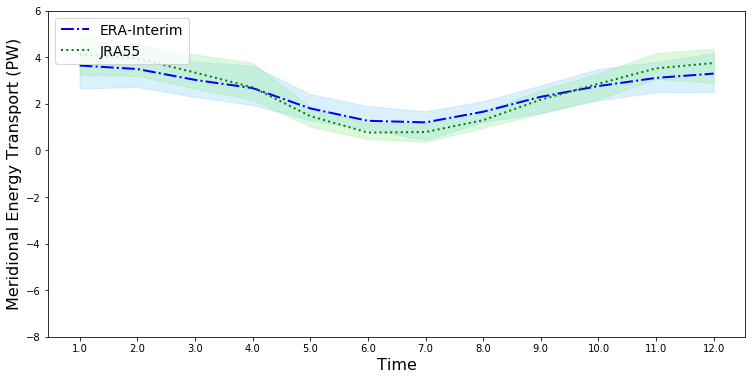

In [10]:
fig9= plt.figure()
plt.plot(np.arange(12),np.mean(AMET_E_ERAI[:],0),'b-.',linewidth=2.0,label='ERA-Interim')
plt.fill_between(np.arange(12),AMET_ERAI_full_annual_mean_max,AMET_ERAI_full_annual_mean_min,alpha=0.3,edgecolor='lightskyblue', facecolor='lightskyblue')
#plt.plot(index_1980_2016[window-1:],AMET_E_JRA55_60_white_running_mean,'m-',linewidth=2.0,label='JRA_60')
plt.plot(np.arange(12),np.mean(AMET_E_JRA55[:],0),'g:',linewidth=2.0,label='JRA55')
plt.fill_between(np.arange(12),AMET_JRA55_full_annual_mean_max,AMET_JRA55_full_annual_mean_min,alpha=0.3,edgecolor='lightgreen', facecolor='lightgreen')
#plt.title('Running Mean of AMET Anomalies at %dN with a window of %d months' % (lat_interest_list[i],window))
fig9.set_size_inches(12.5, 6)
plt.xlabel("Time",fontsize=16)
plt.xticks(np.arange(12),np.linspace(1, 12, 12))
#plt.xticks(rotation=60)
plt.yticks(np.arange(-8,7,2))
plt.ylabel("Meridional Energy Transport (PW)",fontsize=16)

plt.legend(frameon=True, loc=2, prop={'size': 14})
plt.show()
fig9.savefig(output_path + os.sep + 'Comp_AMET_annual_cycle.png', dpi = 300)
plt.close(fig9)

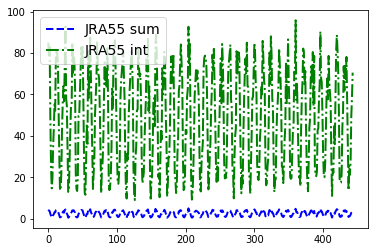

In [7]:
AMET_E_JRA55_series = AMET_E_JRA55.reshape(len(year_JRA55)*12)
AMET_E_JRA55_series_int_polar = AMET_E_JRA55_int_polar.reshape(len(year_JRA55)*12)

fig2= plt.figure()
plt.plot(np.arange(len(AMET_E_JRA55_series)),AMET_E_JRA55_series,'b--',linewidth=2.0,label='JRA55 sum')
plt.plot(np.arange(len(AMET_E_JRA55_series_int_polar)),AMET_E_JRA55_series_int_polar,'g-.',linewidth=2.0,label='JRA55 int')
plt.legend(frameon=True, loc=2, prop={'size': 14})
plt.show()
fig2.savefig(output_path + os.sep + 'Comp_AMET_int_sum_JRA55.png', dpi = 300)
plt.close(fig2)